# Final training and predictions

Load all necessary items like before. This time cutting corners with the descriptions - they can be found from earlier notebooks which have identical data loading structure

In [1]:
import datetime
import io
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split

import torchvision.models as models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

from src.data.preprocess_data import DatasetManager
from src.features.dimension_reduction import fit_pca, load_cnn_embedding

# S3 bucket
import boto3
from dotenv import dotenv_values

EMOTION_LIST = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
LOG_PATH = "/logs"
MODEL_PATH = 'models/resnet50'

# Set values
BATCH_SIZE = 8
VAL_SIZE = 0.2
TEST_SIZE = 0.2
N_EPOCHS = 100
INPUT_SIZE = 224
N_FEATURES = len(EMOTION_LIST)


In [21]:
test_preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(INPUT_SIZE),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

torch_manager = DatasetManager(batch_size=BATCH_SIZE, test_size=TEST_SIZE, 
                        validation_size=VAL_SIZE, transform=test_preprocess, 
                        test_transform=test_preprocess)

train_loader, test_loader, val_loader = torch_manager.load_dataloaders(shuffle_test=True)

Training on test data can be seen as fine-tuning, so let's fine tune with small batch size and small learning rate so observe how our model behaves. https://arxiv.org/pdf/1712.07628.pdf. This paper states that with SGD and correct hyperparameters we should be able to reach better convergence, but they searched for correct hyperparameters for 3 weeks on 16 Tesla K80 GPUs, which demonstrates how hard problem this is. 

In [15]:
RESNET_NAME = 'resnet-50.pt'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

resnet = models.resnet50(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 2048),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(2048, 1024),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(1024,  N_FEATURES)
)

checkpoint = torch.load('../models/' + RESNET_NAME)
# checkpoint = load_torch_model(RESNET_NAME)
resnet.load_state_dict(checkpoint['model_state_dict'])
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [54]:
optim = torch.optim.SGD(resnet.parameters(), lr=0.00001, momentum=0.9) # LR was dropped from 0.0001 to 0.00001

class_weights = torch_manager.calculate_class_weights()
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

C:\Users\teemu\anaconda3\envs\pytorchEnv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0. 1. 2. 3. 4. 5. 6.], y=[0. 0. 0. ... 6. 6. 6.] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [66]:
import timeit

for n_epoch in range(N_EPOCHS):
    preds = []
    ys = []
    loss_history = []
    acc_history = []
    val_loss = 0
    resnet.train()
    # here data loaders were changed multiple times between val/test to get even training distributions
    for i, batch in enumerate(val_loader):
        optim.zero_grad()
        X, y = batch[0].to(device), batch[1].to(device)

        outputs = resnet(X)
        y = y.long()
        loss = criterion(outputs, y)
        loss.backward()
        optim.step()
        
        loss_history.append(loss.detach())
        preds.append(outputs.detach())
        ys.append(y.detach())
        
        if i % 10 == 0 and i > 10:
            y_pred = torch.stack([item.topk(1)[-1] for array in preds for item in array]).squeeze()
            y_stack = torch.stack([item for array in ys for item in array]).squeeze()
            length = len(y_stack)
            print(f"{i}: accuracy: {(y_pred == y_stack).sum() / length}")

        
    val_loss_history = []
    val_acc_history = []
    preds_val = []
    ys_val = []
    resnet.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            X, y = batch[0].to(device), batch[1].to(device)

            outputs = resnet(X)
            y = y.long()
            loss = criterion(outputs, y)

            val_loss_history.append(loss.detach())
            preds_val.append(outputs.detach())
            ys_val.append(y.detach())

    y_pred_val = torch.stack([item.topk(1)[-1] for array in preds_val for item in array]).squeeze()
    y_stack_val = torch.stack([item for array in ys_val for item in array]).squeeze()
    length_val = len(y_stack_val)
    print(f"{i}: accuracy val: {(y_pred_val == y_stack_val).sum() / length_val}")
    print(f"{i}: loss val: {sum(val_loss_history) / len(val_loss_history)}")

    acc = (y_pred == y_stack).sum() / length
    
    mu_loss_train = sum(loss_history) / len(loss_history)
    print(f"TRAINING: epoch: {n_epoch}, loss: {mu_loss_train}, acc: {acc}")

20: accuracy: 0.625
30: accuracy: 0.5846773982048035
40: accuracy: 0.5914633870124817
50: accuracy: 0.5710784792900085
60: accuracy: 0.5778688192367554
70: accuracy: 0.5968309640884399
80: accuracy: 0.5895061492919922
90: accuracy: 0.5769230723381042
100: accuracy: 0.5693069100379944
110: accuracy: 0.5675675868988037
120: accuracy: 0.5702478885650635
130: accuracy: 0.569656491279602
140: accuracy: 0.5797871947288513
150: accuracy: 0.5778145790100098
160: accuracy: 0.5799689292907715
170: accuracy: 0.5840643048286438
180: accuracy: 0.5856353640556335
190: accuracy: 0.5837696194648743
200: accuracy: 0.5833333134651184
210: accuracy: 0.5853080749511719
220: accuracy: 0.5825791954994202
230: accuracy: 0.5811688303947449
240: accuracy: 0.5814315676689148
250: accuracy: 0.5801792740821838
260: accuracy: 0.5780650973320007
270: accuracy: 0.5793358087539673
280: accuracy: 0.5765124559402466
290: accuracy: 0.5773196220397949
300: accuracy: 0.5747508406639099
310: accuracy: 0.5755627155303955
32

KeyboardInterrupt: 

Save the trained model

In [68]:
torch.save(resnet, '../models/finetuned-resnet-best-acc.pt')

Evaluate once more on specified data loader

In [82]:
predictions = []
resnet.eval()
with torch.no_grad():
    for batch in test_loader:
        X, y = batch[0].to(device), batch[1].to(device)

        outputs = loaded_model(X)
        preds = outputs.topk(1)[-1]
        y = y.long()
        
        scores = {'predictions': preds, 'true': y}
        predictions.append(scores)
        
y_true = [element.detach().cpu().numpy() for array in predictions for element in array['true']]
y_pred = [element.detach().cpu().numpy() for array in predictions for element in array['predictions']]
y_true = np.array(y_true)
y_pred = np.array(y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.827579365079365

## Do the final predictions for the test data

In [72]:
loaded_model = torch.load('../models/finetuned-resnet-best-acc.pt')

In [75]:
test_directory = '../data/test'
imgs = []
for img in os.listdir('../data/test'):
    loaded_image = Image.open('../data/test/' + img)
    imgs.append(np.asarray(loaded_image))
stacked_imgs = np.stack(imgs)

Predict

In [81]:
test_predictions = []
resnet.eval()
with torch.no_grad():
    for X in stacked_imgs:
        X = np.stack((X.squeeze(),)*3, axis=-1) # 1 channel to 3 channels
        X = test_preprocess(X).unsqueeze(0).to(device)

        outputs = loaded_model(X)
        preds = outputs.topk(1)[-1]
    
        test_predictions.append(preds)

In [90]:
final_predictions = np.stack([y.detach().cpu().numpy().astype(np.int) for x in test_predictions for y in x]).squeeze()

In [95]:
final_predictions

numpy.ndarray

Save to file

In [96]:
np.savetxt("../test_results/test_predictions.csv", final_predictions, delimiter=',', fmt='%d')

Plot distribution for sanity check

(array([680.,  98., 485., 865., 648., 472., 790.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

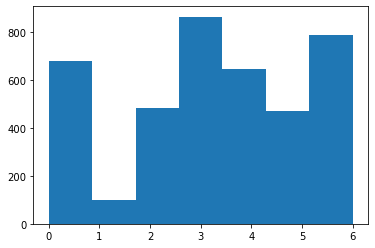

In [98]:
plt.hist(final_predictions, bins=7)

# Looks just about right data distribution for our model. Thank you!